In [1]:
from EmetMamba import EmetConfig, EmetMamba
import torch

# Creating the Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import numpy as np
from dataclasses import dataclass


# Function to pad an array to a specific shape
def to_shape(a, shape):
    # Unpack the target shape
    y_, x_ = shape

    # Get the current shape of the array
    y, x = a.shape

    # Calculate the padding needed in the y and x directions
    y_pad = y_ - y
    x_pad = x_ - x
    output = np.zeros()
    # Pad the array using numpy's pad function
    return np.pad(
        a,
        [(0, 1), (0, 1)],
        # Calculate the padding for each dimension
        #((y_pad // 2, y_pad // 2 + y_pad % 2), (x_pad // 2, x_pad // 2 + x_pad % 2)),
        mode="constant",
    )


# Function to pad data and labels to a specific shape
def apply_padding(data_df, N, T_max):
    # Define the final shape of the data and labels
    final_shape = (N, T_max, 3)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)
    final_label = np.zeros((N, T_max, 3))

    # Select a random subset of trajectory indices
    if len(data_df["traj_idx"].unique()) < N:
        selected_ids = data_df["traj_idx"].unique()
    else:
        selected_ids = np.random.choice(
            data_df["traj_idx"].unique(), size=N, replace=False
        )

    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()
        # print(exp["frame"])
        label = exp[["alpha", "D", "state"]].to_numpy()

        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:
            final_data[n, :, :] = data[:T_max, :]
            final_label[n, :, :] = label[:T_max, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, :data.shape[0], :] = data
            final_label[n, :data.shape[0], :] = label

    # Return the padded data and labels
    return final_data, final_label


# Define a function to normalize data
def normalize_df(data):
    # Calculate displacement in x and y directions
    # Normalize by substring mean and dividing by variance.

    displacement_x = []
    displacement_y = []
    for _, group in data.groupby("traj_idx"):
        x = np.asarray(group["x"])
        y = np.asarray(group["y"])
        d_x = x[1:] - x[:-1]
        d_y = y[1:] - y[:-1]
        displacement_x = displacement_x + list(d_x)
        displacement_y = displacement_y + list(d_y)

    # Calculate variance in x and y directions
    variance_x = np.sqrt(np.std(displacement_x))
    variance_y = np.sqrt(np.std(displacement_y))

    # Normalize data
    data.loc[:, "x"] = (data["x"] - data["x"].mean()) / variance_x
    data.loc[:, "y"] = (data["y"] - data["y"].mean()) / variance_y


def normalize_np(data):

    displacement_x = []
    displacement_y = []
    for n in range(data.shape[0]):
        x = data[n, :, 1]
        y = data[n, :, 2]
        d_x = x[1:] - x[:-1]
        d_y = y[1:] - y[:-1]
        displacement_x = displacement_x + list(d_x)
        displacement_y = displacement_y + list(d_y)

    # Calculate variance in x and y directions
    variance_x = np.sqrt(np.std(displacement_x))
    variance_y = np.sqrt(np.std(displacement_y))

    # Normalize data

    data[:, :, 1] = (data[:, :, 1] - np.mean(data[:, :, 1])) / variance_x
    data[:, :, 2] = (data[:, :, 2] - np.mean(data[:, :, 2])) / variance_x

    return data


# Define a function to list directory tree with pathlib
def list_directory_tree_with_pathlib(starting_directory):
    path_object = Path(starting_directory)
    folders = []
    for file_path in path_object.rglob("*.csv"):
        folders.append(file_path)
    return folders


# Define a custom dataset class for all data
@dataclass
class Dataset_all_data(Dataset):
    # Initialize filenames and transform flag
    # Pad value should be a tuple such as (N, Tmax)
    filenames: list
    transform: bool = False
    pad: None | tuple = None
    noise: bool = False

    def __len__(self):
        # Return the number of files
        return len(self.filenames)

    def __getitem__(self, idx):
        # Read csv file and extract data and label
        df = pd.read_csv(self.filenames[idx])

        if self.pad is None:
            data = df[["traj_idx", "frame", "x", "y"]]
            label = np.asarray(df[["alpha", "D"]])
            label_2 = np.asarray(df["state"])

        else:
            if len(self.pad) != 2:
                raise ValueError("pad value should be set as (N, T_max)")
            data, label = apply_padding(df, *self.pad)
            label_2 = label[:, :, -1]
            label_2[label_2[:, :] > 0] = label_2[label_2[:, :] > 0] - 1
            label = label[:, :, :-1]

        # Normalize data if transform flag is True
        if self.transform:
            if self.pad is None:
                normalize_df(data)
                data = np.asarray(data)
            else:
                data = normalize_np(data)

        if self.noise:
            data = add_noise(data)
            

        # Return data and label
        return torch.from_numpy(data.astype(np.float32)), (
            torch.from_numpy(label.astype(np.float32)),
            torch.from_numpy(label_2.astype(np.float32)),
        )
    
def add_noise(data):
    noise_amplitude = np.random.choice([0.01, 0.1, 1])
    noise = np.random.normal(0, noise_amplitude, data[:,:,1:].shape)
    data[:,:,1:] = data[:,:,1:] + data[:,:,1:]*noise
    return  data

In [3]:
# [x["frame"].iloc[-1] - x["frame"].iloc[0] for _, x in df.groupby("traj_idx")]

In [4]:
all_data_set = list_directory_tree_with_pathlib(
    r"/home/m.lavaud/Documents/Zeus/I2/T_500_const_100_to_150/batch_T_Const_1",
)

In [5]:
import random

random.shuffle(all_data_set)

In [6]:
training_dataset = Dataset_all_data(all_data_set, transform=False, noise=True, pad=(50, 200))

In [7]:
a = next(iter(training_dataset))

In [8]:
a[0][6,:,0]

tensor([301., 302., 303., 304., 305., 306., 307., 308., 309., 310., 311., 312.,
        313., 314., 315., 316., 317., 318., 319., 320., 321., 322., 323., 324.,
        325., 326., 327., 328., 329., 330., 331., 332., 333., 334., 335., 336.,
        337., 338., 339., 340., 341., 342., 343., 344., 345., 346., 347., 348.,
        349., 350., 351., 352., 353., 354., 355., 356., 357., 358., 359., 360.,
        361., 362., 363., 364., 365., 366., 367., 368., 369., 370., 371., 372.,
        373., 374., 375., 376., 377., 378., 379., 380., 381., 382., 383., 384.,
        385., 386., 387., 388., 389., 390., 391., 392., 393., 394., 395., 396.,
        397., 398., 399., 400., 401., 402., 403., 404., 405., 406., 407.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   

In [9]:
import torch.nn as nn
import torch.optim as optim

## Setting up the model

The different hyperparameters are below, and will have to be modified 

In [10]:
learning_rate = 1e-2
max_epochs = 10
max_particles = 20
max_traj_len = 200


training_dataset = Dataset_all_data(
    all_data_set[:500], transform=False, pad=(max_particles, max_traj_len)
)
dataloader = DataLoader(training_dataset, shuffle=True, batch_size=10, num_workers=1)
len_exp = max_particles * max_traj_len


config = EmetConfig(
    d_model=3,
    n_layers=16,
    dt_rank="auto",
    d_state=16,
    expand_factor=2,
    d_conv=4,
    dt_min=0.001,
    dt_max=0.1,
    dt_init="random",
    dt_scale=1.0,
    rms_norm_eps=1e-5,
    bias=False,
    conv_bias=True,
    inner_layernorms=False,
    pscan=True,
    use_cuda=True,
    bi_mamba_stacks=1,
    conv_stack=3,
    dropout=0.05,
)

importing gpu Mamba


/home/m.lavaud/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
model = EmetMamba(config=config)

In [12]:
model.train()

EmetMamba(config=EmetConfig(d_model=3, n_layers=16, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, bias=False, conv_bias=True, inner_layernorms=False, pscan=True, use_cuda=True, bi_mamba_stacks=1, conv_stack=3, dropout=0.05))

In [13]:
from tqdm import tqdm

In [14]:
classification_criterion = nn.CrossEntropyLoss()
# Define optimizer
running_total_loss = []
running_classification_loss = []
running_regression_loss = []
model = EmetMamba(config=config)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))


regression_criterion = RMSLELoss()

for epoch in range(max_epochs):
    with tqdm(dataloader, unit="batch") as tepoch:
        running_loss = []
        for inputs, (regression_targets, classification_targets) in tepoch:
        # for inputs, classification_targets in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            inputs = inputs.to("cuda")
            # classification_targets = torch.flatten(
            #     classification_targets, start_dim=1, end_dim=2
            # ).type(torch.LongTensor)
            # classification_targets = classification_targets.to("cuda")

            regression_targets = torch.flatten(
                regression_targets, start_dim=1, end_dim=2
            ).to("cuda")
            optimizer.zero_grad()
            #classification_output, regression_output = model(inputs)

            regression_output = model(inputs)

            regression_loss = regression_criterion(
                regression_output, regression_targets
            )
            # classification_loss = classification_criterion(
            #     classification_output.view(-1, 3).to("cpu"),
            #     classification_targets.view(-1).to("cpu"),
            # )
            # classification_loss = classification_loss.to("cuda")
            total_loss =  regression_loss #classification_loss 
            total_loss.backward()
            optimizer.step()

            tepoch.set_postfix(
                loss=total_loss.item(),
                # regression_loss=regression_loss.item(),
                # classification_loss=classification_loss.item(),
            )
            running_loss.append(total_loss.item())
        running_total_loss.append(np.mean(running_loss))
        # running_regression_loss.append(classification_loss.item())
        # running_regression_loss.append(regression_loss.item())
# Evaluation
model.eval()

  0%|          | 0/50 [00:00<?, ?batch/s]

Epoch 9: 100%|██████████| 50/50 [01:01<00:00,  1.22s/batch, loss=0.353]


EmetMamba(config=EmetConfig(d_model=3, n_layers=16, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, bias=False, conv_bias=True, inner_layernorms=False, pscan=True, use_cuda=True, bi_mamba_stacks=1, conv_stack=3, dropout=0.05))

In [17]:
import matplotlib.pyplot as plt

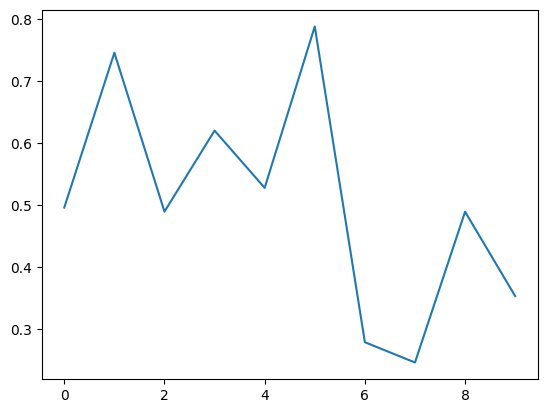

In [18]:
plt.figure()
plt.plot(running_total_loss)
